# Second Hand Car Price Prediction
This project is modified from a homework I did with one of my classmates (Bo Jumrustanasan) on the course COMS 4995 Applied Machine Learning by Dr. Andreas C. Müller at Columbia University. The aim is to predict the the price of a used vehicle on craigslist ([data](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)). The project includes the following parts:

1. data visualization
2. data preprocessing and imputation using pipelines
3. grid search on Linear Regression, Elastic Net, and LinearSVR to build a baseline linear model
4. modeling with text features using Bag of Words (BoW) and word-embedding

The final model is a Linear Regression model with BoW and word-embedding. The test accuracy is 77%.

## Load packges and data
Due to limited computation resources, we only sampled 10% data (~50k records) from the orginal data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import math

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#import shap
from sklearn.feature_selection import SelectFromModel
#from sklearn.pipeline import make_pipeline

In [2]:
# # sampling
# vehicles = pd.read_csv("../../data/vehicles.csv")
# n = math.ceil(vehicles.shape[0] * .03)
# vehicles = vehicles.sample(n, replace=False).reset_index(drop=True)
# vehicles.to_csv("../../data/sample_vehicles.csv", index=False)
# print(n)

In [3]:
# load sample data
vehicles = pd.read_csv("../../data/sample_vehicles_test.csv")

## Exploratory data analysis and data cleaning

### Missing data
We found that the missing correlations of a feature pair are so low that we consider it missing at random. This justifies a complete case analysis in further process. In the follow plots:
* Left: White indicates missing
* Right: Perfectly incorrelated is represented as 0

### Data cleaning
We conducted the following steps to clean the data and identify features:

1. **Columns**: Keep only features that we think are useful for price prediction for further inspection. Almost all data points have unique `id`, `url`, `image_url`, `VIN`, `model`, and `description`. If these features are included, a model may associate the value to the price and will not be able to generalize well. `description` also leaks target information because it contains the price in the text. We belive that the variation in `state` is more informative than in `region`. We keep the following 13 features:

   * `year`, `manufacturer`, `condition`, `cylinders`, `fuel`, `odometer`, `transmission`, `drive`, `size`, `type`, `paint_color`, `state`, `title_status` .
   
   And dropped the following 12 features for the above reasons and also because too much missing values (e.g. `county` has all values missing):
   * `id`, `url`, `region_url`, `VIN`, `image_url`, `description`, `county`, `lat`, `long`, `posting_date`, `region`, `model`.
   
2. **Rows**: Remove rows with outliers and unreasonable values. It is unreasonable for selling a (used) car for less than 1,000 or greater than 100,000; those with odometer higher than 1,000,000 are also treated as outliers. They are not a good representation of the data.
3. Convert `cylinders` (string) to numeric.

missing percentage:
county          1.000000
size            0.709378
cylinders       0.419770
condition       0.411806
VIN             0.382447
drive           0.302100
paint_color     0.297962
type            0.219724
manufacturer    0.039041
title_status    0.019286
long            0.013821
lat             0.013821
model           0.012415
odometer        0.010073
fuel            0.008042
transmission    0.006247
year            0.002889
description     0.000312
image_url       0.000312
posting_date    0.000312
dtype: float64


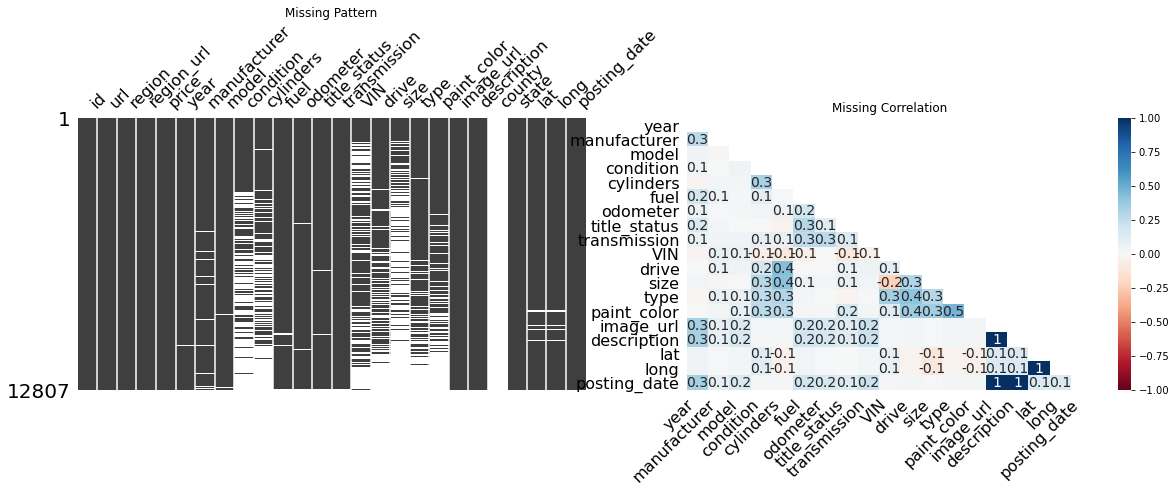

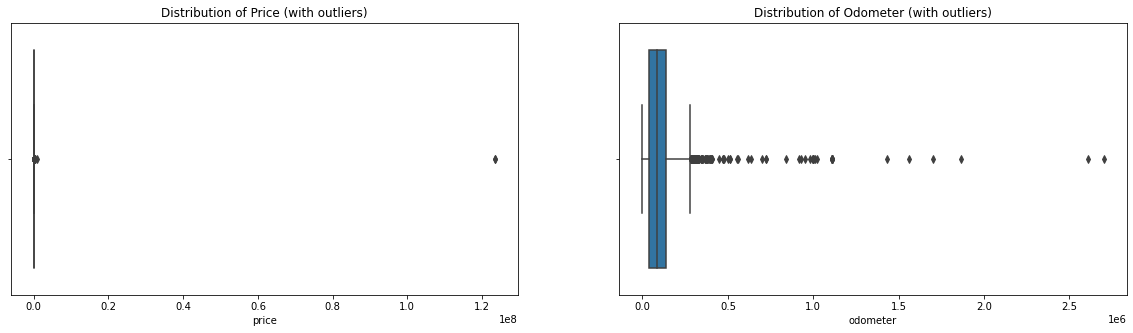

In [4]:
# check missing
## percent missing in each feature
missing_per=(vehicles.isnull().sum()[vehicles.isnull().sum()>0]/vehicles.shape[0]).sort_values(axis='index',ascending=False)
print("missing percentage:\n{}".format(missing_per))

fig,ax = plt.subplots(1,2, figsize=(20,5))
msno.matrix(vehicles, sort="descending", sparkline=False, ax=ax[0]) # White = missing
msno.heatmap(vehicles, figsize=(10,5), ax=ax[1]) # Ideally want 0 missing correlation
ax[0].set_title('Missing Pattern');
ax[1].set_title('Missing Correlation');

# check outlier
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.boxplot(vehicles.price,ax=ax[0]);
sns.boxplot(vehicles.odometer,ax=ax[1]);
ax[0].set_title("Distribution of Price (with outliers)");
ax[1].set_title("Distribution of Odometer (with outliers)");

In [5]:
# data cleaning
pd.options.mode.chained_assignment = None  # mute warnings (default='warn')

# drop missing rows and outliers
vehicles = vehicles[~((vehicles.price<1e3)|(vehicles.price>1e5)|(vehicles.odometer>1e6))]

### Identify features through visualization
We consider the features as:

* Continuous: `year`, `odometer`
* Categorical: `title_status`, `fuel`, `transmission`, `drive`, `type`, `manufacturer`, `paint_color`, `state`
* Ordinal: `condition`, `size`, `cylinders`

We visualize univariate relationships between each feature and the target `price`. Some interesting features are: 

* `cylinder`:
   * Considering only common cylinders (4, 6, and 8), a car with 8 cylinders portrays higher price
   * 12 cylinder has distinctively high price (we found later that because there is only a couple of data points)
* `condition`:
   * Natural ordering intuitively reflect the price well. (New is the highest and salvage is the lowest.)
* `size`:
   * Full-size cars have the highest median price
* `year`: 
    * A newer model has a higher median price.
* `odometer`:
    * A car with high odometer has a lower median price.

No patterns are observed in other features due to too few data points (e.g. manufacturer Tesla has significantly high price). However, we decide to keep most of them for further inspection because they are intuitive predictors for the selling price.

In [6]:
categorical = ['fuel','transmission', 'drive','type',
               'manufacturer','paint_color', 'state', 'title_status']
ordinal = ['condition','size','cylinders']
continuous = ['year','odometer']

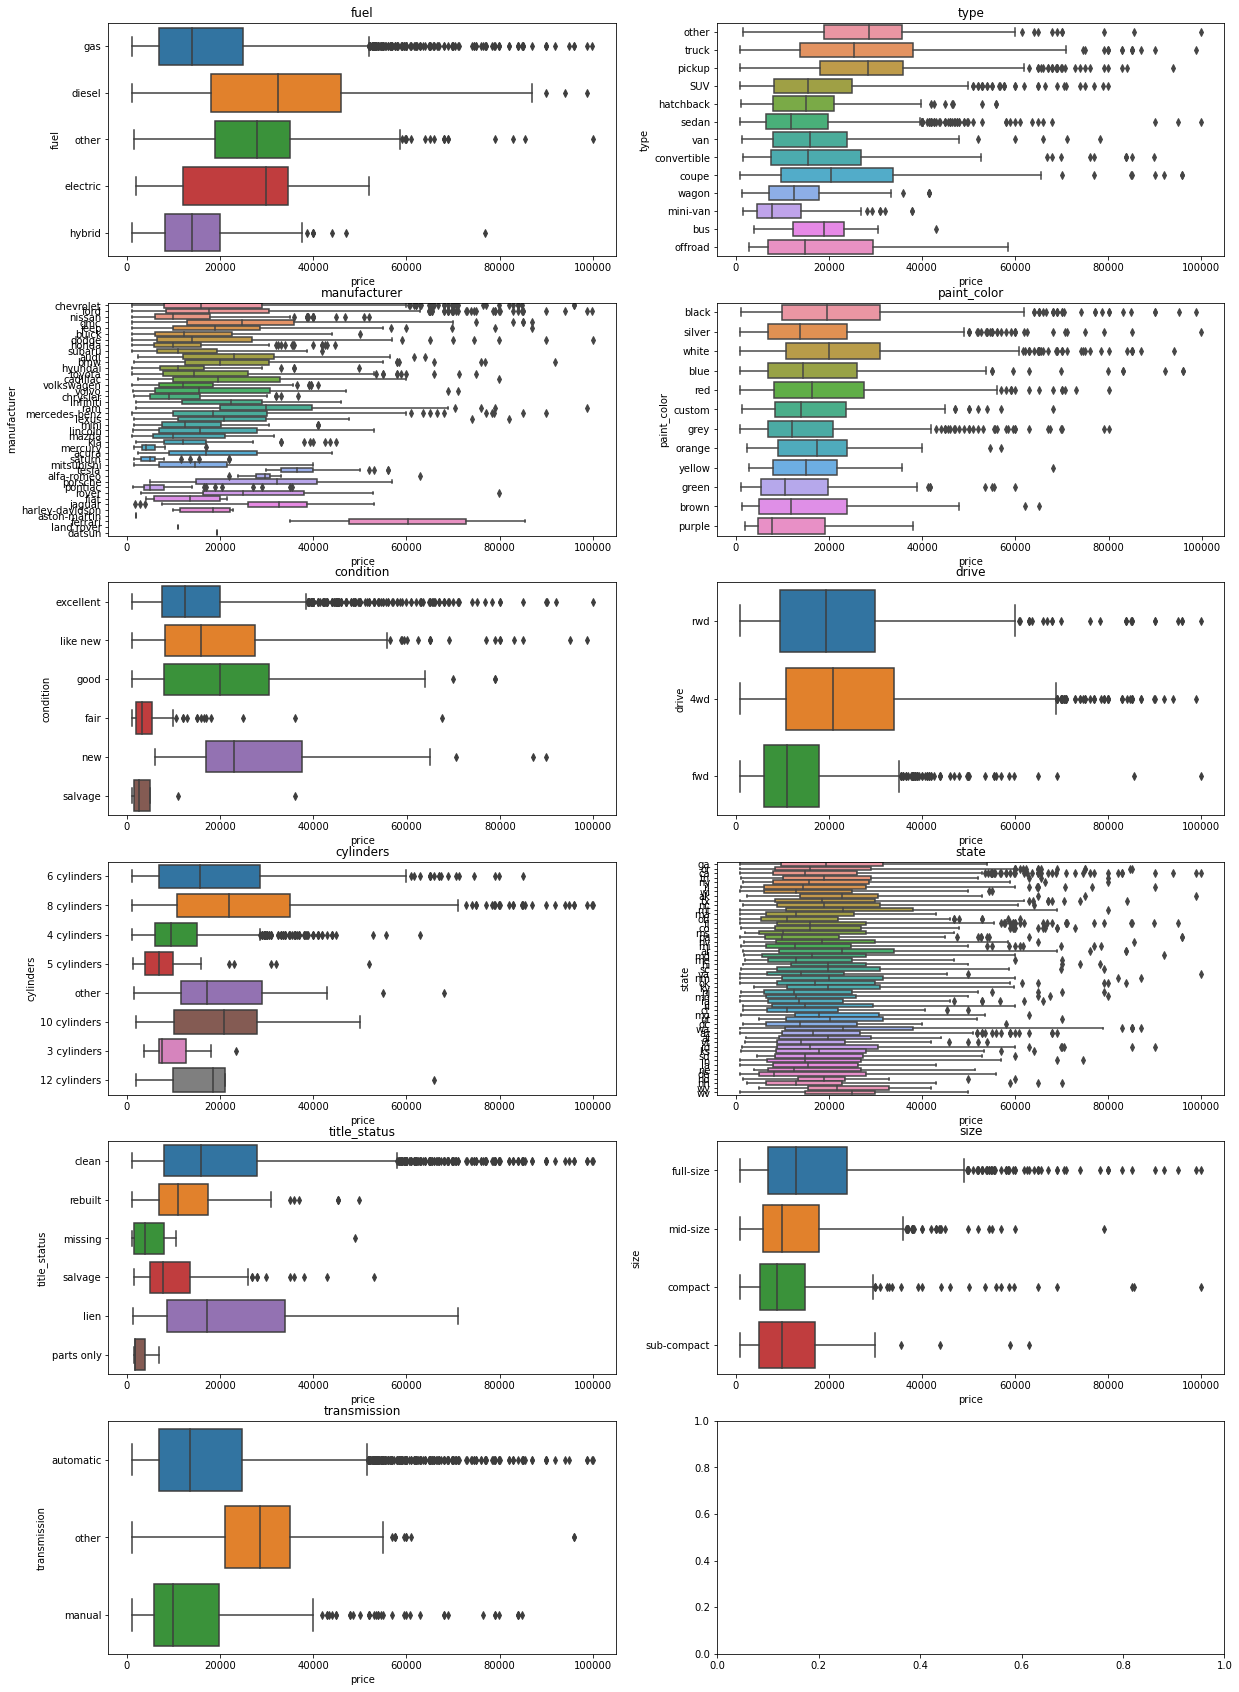

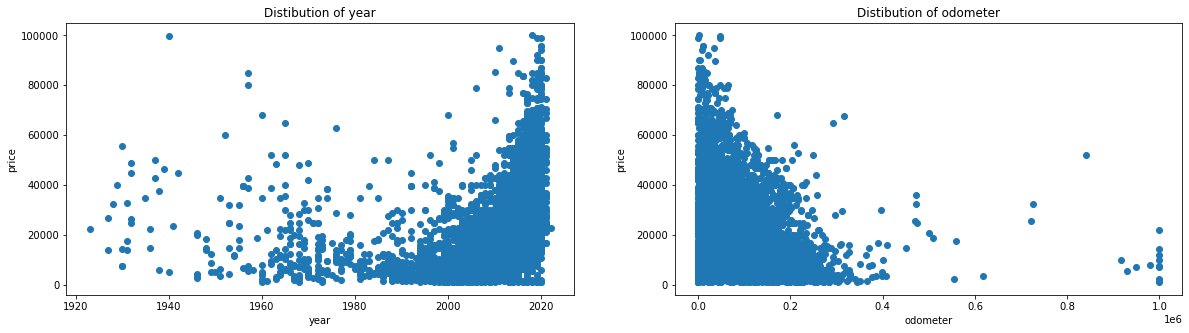

In [7]:
# boxplot for categorical variables using seaborn
feature = list(set(categorical+ordinal))
fig,ax = plt.subplots(6,2,figsize=(20,30))
for i in range(0,6):
    if i != 5:
        for j in range(0,2):
            sns.boxplot(y=vehicles[feature[i*2+j]], x=vehicles.price, ax=ax[i,j],orient="h").set_title(feature[i*2+j])
    else:
        sns.boxplot(y=vehicles[feature[i*2]], x=vehicles.price, ax=ax[i,0],orient="h").set_title(feature[i*2])

# continuous variables
fig,ax=plt.subplots(1,2,figsize=(20,5))
for i in range(0,2):
    ax[i].scatter(vehicles[continuous[i]],vehicles.price)
    ax[i].set_xlabel(continuous[i])
    ax[i].set_ylabel('price')
    ax[i].set_title('Distibution of {}'.format(continuous[i]))

## Preprocessing and Baseline model

### Baseline model
We use a Linear regression model as the baseline model because it is simple to implement. For the baseline model, only the following features are being used:
* Continuous: `year`, `odometer`
* Categorical: `title_status`, `fuel`, `transmission`, `drive`, `state`, `type`
* Ordinal: `condition`, `size`, `cylinders`

`manufacturer`, `paint_color` are removed from the training data for the baseline model because they have many unique values and one-hot encoding those features will make the model have much more variable and less explainable. Using only six categorical variables allows for a reduced number of coefficients, which is good for a baseline model that serves as an initial approach to the data.

### Preprocessing
We preprocessed the data in following steps:

* drop outliers in `price` (less than 1,000 or greater than 100,000) and `odometer` (higher than 1,000,000)
* deal with missing values (imputation with mean or mode)
* standardize `odometer` (we did not standardize `year` because it does not make sense)
* target encode `state`
* one-hot encode other categprical variables （`title_status`, `fuel`, `transmission`, `drive`）

In [8]:
def pipe_preprocess(impute=True, continuous=[], target=[], categorical=[], ordinal=[], ord_cat=[],other_imp=[]):
    if impute:
        cat_preprocessing = Pipeline([('cat_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='most_frequent')),
                                      ('cat_pre',OneHotEncoder(handle_unknown ='ignore', drop='first'))])  # this will make the unknown category same as the first dropped category
        # check this post https://github.com/scikit-learn/scikit-learn/issues/18072
        # and https://github.com/scikit-learn/scikit-learn/pull/19041
        ord_preprocessing=Pipeline([('ord_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='most_frequent')),
                                     ('ord_pre',OrdinalEncoder(categories=ord_cat, handle_unknown = 'use_encoded_value', unknown_value = -1))])
        cont_preprocessing=Pipeline([('cont_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='mean')),
                                     ('cont_pre',StandardScaler())])
        imp_preprocessing=Pipeline([('imp',SimpleImputer(missing_values=np.nan,
                                                         strategy='most_frequent'))])
    else:
        cat_preprocessing = Pipeline([('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
        ord_preprocessing = Pipeline([('ord_pre',OrdinalEncoder(categories=ord_cat, handle_unknown = 'use_encoded_value', unknown_value = -1))])
        cont_preprocessing = Pipeline([('cont_pre',StandardScaler())])
        imp_preprocessing = None
                                    
    preprocess = make_column_transformer((cat_preprocessing,categorical),
                                         (ord_preprocessing,ordinal),
                                         (cont_preprocessing,continuous),
                                         (imp_preprocessing,other_imp),
                                         (TargetEncoder(),target),
                                         remainder='passthrough')
    return preprocess

def grid_result(param_grid, X_trainval, y_trainval, preprocess, cv=3):
    """
    Process and apply a grid search on X_trainval and y_trainval.
    Args:
    param_grid: dictionary of parameter settings to be grid searched on
    X_trainval, y_trainval: training and validation data
    preprocess: preprocess pipeline
    cv; # of cross-validation fold
    Return:
    grid object that is fitted on X_trainval and y_trainval
    """
    pipeline = Pipeline([('preprocess',preprocess),
                         ('regressor',LinearRegression())])

    grid = GridSearchCV(pipeline, param_grid, return_train_score=True, cv=cv)
    grid.fit(X_trainval, y_trainval)
    return grid

In [9]:
continuous = ['odometer', 'year']
ordinal = ['condition','size', 'cylinders']
categorical = ['fuel','transmission','drive','title_status','type']
target = ['state']

# reorder ordinal variables for easier interpretation of the model
ord_cat = [['salvage', 'fair', 'like new', 'new', 'good', 'excellent'],
           ['sub-compact','compact', 'mid-size', 'full-size'],
           ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders','other']]

y = vehicles.price
X = vehicles[categorical + ordinal + continuous + target]

## Set global training and test sets
global_X_trainval, global_X_test, global_y_trainval, global_y_test = train_test_split(X, y, random_state=1)

log_ols = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
param_grid=[{'regressor':[LinearRegression()]}]
preprocess = pipe_preprocess(impute=True, continuous=['odometer'], target=target, categorical=categorical, ordinal=ordinal, ord_cat=ord_cat, other_imp=['year'])
grid_cp = grid_result(param_grid, global_X_trainval, global_y_trainval, preprocess, cv=5)

print('The best model:\n {model}\nCV score: {score:.3f}'\
      .format(model=grid_cp.best_params_,score=grid_cp.best_score_))

The best model:
 {'regressor': LinearRegression()}
CV score: 0.519


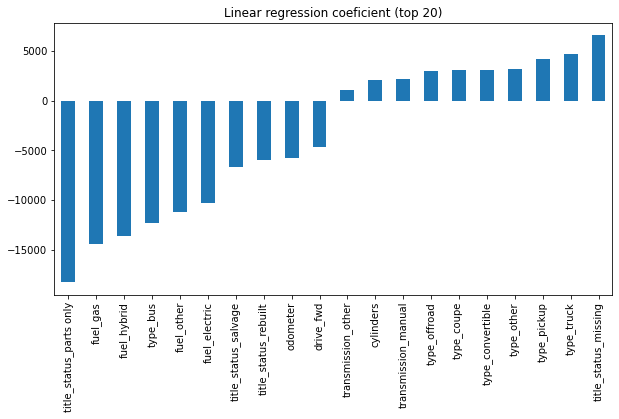

In [94]:
col_names = grid_cp.best_estimator_.named_steps['preprocess'].transformers_[0][1].named_steps['cat_pre'].get_feature_names_out(categorical)
col_names = list(col_names) + ordinal+['odometer']+['year']+target
coef = grid_cp.best_estimator_.named_steps['regressor'].coef_
# coef = grid_cp.best_estimator_.named_steps['regressor'].regressor_.coef_

coef_plot = pd.DataFrame({"Coef":coef}, index = col_names)
coef_plot.sort_values(['Coef']).iloc[[*range(10), *range(-10, 0)]].plot.bar(figsize=(10,5), title='Linear regression coeficient (top 20)', legend=None);

In general, the results make sense. The most important factors seems to be the type and status of a car, which is not surprising given this is characteristic indicates the utility and quality of a car. Truck and pickup car usually have a larger size and tend to be more expensive. Cars with only parts available reduce the value of them. Although it is weird that cars without a title status are more expensive than the baseline (clean title status). It might be because not many sample points are included for this category (19 records, less than 0.1%). The rest of the coefficients also make sense, whith the exception of electric cars being cheaper than the diesel car. We suspect this is because many of these vehicles are not actually cars, but golf carts and similar vehicles.

## Feature Engineering
From the previous task, `cylinders`, `condition`, and `size` are three columns with the most missing values. At this step, we are curious whether we should 

1. impute missing categorical values with the most frequent value.
2. create a new category indicating the missing data.

It turns out that the second methods gives a better validation score (0.571) than the one using the first method (0.566). It makes sense considering the context because having a NaN might give an extra piece of information (e.g. if someone does not include the condition of the car, it may be that she is hiding it and therefore we would expect a lower price).

Based on the baseline model, we made a few modification to the features and pre-processing methods:

* transform output `price` into log form, as price seems to have a log-normal distribution
* included `manufacturer`, `paint_color` and one-hot encode them
* dealing with missing values (create an NaN category)
* rebased year to 1900 to make the value smaller
* include the interaction between ordinal variables (interaction among `cylinders`, `condition`, and `size`)

After the imputation, we also try

1. deriving `paint_color_group` from `paint_color`, which describes car colors into most common, somewhat common, and uncommon color.
2. deriving `use_type` from `type`, which categorized car types into family used and non-family used. 
3. deriving a feature that describes the length of description entry

However, all of the approaches (code not shown) do no better than the current feature engineering.

In [10]:
def pipe_preprocess(impute=True, continuous=[], target=[], categorical=[], ordinal=[], ord_cat=[], other_imp=[]):
    if impute:
        cat_preprocessing = Pipeline([('cat_imp',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                      ('cat_pre',OneHotEncoder(handle_unknown ='ignore', drop='first'))])  # this will make the unknown category same as the first dropped category
        # check this post https://github.com/scikit-learn/scikit-learn/issues/18072
        # and https://github.com/scikit-learn/scikit-learn/pull/19041
        ord_preprocessing=Pipeline([('ord_imp',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                    ('ord_pre',OrdinalEncoder(categories=ord_cat, handle_unknown = 'use_encoded_value', unknown_value = -1)),
                                    ('ord_poly',PolynomialFeatures(interaction_only=True, include_bias=False))])
        cont_preprocessing=Pipeline([('cont_imp',SimpleImputer(missing_values=np.nan, strategy='mean')),
                                     ('cont_pre',StandardScaler())])
        imp_preprocessing=Pipeline([('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])
    else:
        cat_preprocessing = Pipeline([('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
        ord_preprocessing = Pipeline([('ord_pre',OrdinalEncoder(categories=ord_cat, handle_unknown = 'use_encoded_value', unknown_value = -1))])
        cont_preprocessing = Pipeline([('cont_pre',StandardScaler())])
        imp_preprocessing = None
        
    preprocess = make_column_transformer((cat_preprocessing,categorical),
                                         (ord_preprocessing,ordinal),
                                         (cont_preprocessing,continuous),
                                         (imp_preprocessing,other_imp),
                                         (TargetEncoder(),target),
                                         remainder='passthrough')

    return preprocess

In [61]:
continuous = ['odometer', 'year']
ordinal = ['condition','size', 'cylinders']
categorical = ['fuel','transmission','drive','title_status','type',
               'manufacturer','paint_color']
target = ['state']

y = vehicles.price
X = vehicles[categorical + ordinal + continuous + target]
X['year'] = X['year'] - 1900

X[ordinal+categorical] = X[ordinal+categorical].fillna('miss')
# # reorder ordinal variables for easier interpretation of the model
# X['condition'] = X['condition'].astype('category').cat.reorder_categories(['miss','salvage', 'fair', 'like new', 'new', 'good', 'excellent'])
# X['size'] = X['size'].astype('category').cat.reorder_categories(['miss','sub-compact','compact', 'mid-size', 'full-size'])
# X['cylinders'] = X['cylinders'].astype('category').cat.reorder_categories(['miss','3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders','other'])

## Set global training and test sets
global_X_trainval, global_X_test, global_y_trainval, global_y_test = train_test_split(X, y, random_state=1)

In [62]:
log_ols = TransformedTargetRegressor(LinearRegression(),func=np.log,inverse_func=np.exp)
# log_en = TransformedTargetRegressor(ElasticNet(tol = 1),func=np.log,inverse_func=np.exp)
# log_svr = TransformedTargetRegressor(LinearSVR(tol = 1),func=np.log,inverse_func=np.exp)

# param_grid=[{'regressor':[log_ols]},
#             {'regressor':[log_en],
#              'regressor__regressor__alpha': np.logspace(-5,1,7),
#              'regressor__regressor__l1_ratio': [0,0.01, .1, .5, .98, 1]},
#             {'regressor':[log_svr],
#              'regressor__regressor__C':np.logspace(-5,1,7)}]
param_grid=[{'regressor':[log_ols]}]

preprocess = pipe_preprocess(impute=True, continuous=continuous, target=target, 
                             categorical=categorical, ordinal=ordinal, ord_cat=ord_cat)
grid_cp = grid_result(param_grid, global_X_trainval, global_y_trainval, preprocess, cv=5)

print('The best model:\n {model}\nCV score: {score:.3f}'\
      .format(model=grid_cp.best_params_,score=grid_cp.best_score_))

The best model:
 {'regressor': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())}
CV score: 0.571


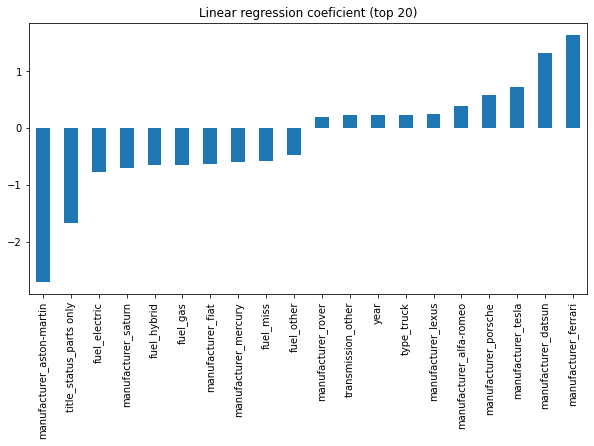

In [64]:
col_names = list(grid_cp.best_estimator_.named_steps['preprocess'].transformers_[0][1].named_steps['cat_pre'].get_feature_names_out(categorical))+\
            list(grid_cp.best_estimator_.named_steps['preprocess'].transformers_[1][1].named_steps['ord_poly'].get_feature_names_out(ordinal))+\
            ['odometer']+['year']+target
# coef = grid_cp.best_estimator_.named_steps['regressor'].coef_
coef = grid_cp.best_estimator_.named_steps['regressor'].regressor_.coef_

coef_plot = pd.DataFrame({"Coef":coef}, index = col_names)
coef_plot.sort_values(['Coef']).iloc[[*range(10), *range(-10, 0)]].plot.bar(figsize=(10,5), title='Linear regression coeficient (top 20)', legend=None);

## Grid Search with Random Forest and Gradient Boosting

In addition to Linear Regression, we train models with

* GradientBoosting and
* Random Forest

and conducted Grid Search on the hyperparameters (code shown below).

The \\(R^2\\) of validation set improves from 0.57 to 0.79 when we use gradient boosting with the following hyperparameters
* loss = `huber`
* learning_rate = `0.1`
* max_depth = `9`

The test score is 0.791.

We further tried to introduce new features: "**length of description**" and "**spaces in description**" into the model, but they did not significantly improves the model performance. (Code not shown).

In [150]:
import warnings
warnings.filterwarnings("ignore")

log_gbr=TransformedTargetRegressor(GradientBoostingRegressor(warm_start = True),func=np.log,inverse_func=np.exp)
log_rfr=TransformedTargetRegressor(RandomForestRegressor(warm_start = True),func=np.log,inverse_func=np.exp)

param_grid=[{'regressor':[log_gbr],
             'regressor__regressor__loss': ['squared_error', 'absolute_error', 'huber'],
             'regressor__regressor__learning_rate': [0.001, 0.01, 0.1, 0.5],
             'regressor__regressor__max_depth': [7,9,11]},
            {'regressor':[log_rfr],
             'regressor__regressor__max_depth': [7,9,11],
             'regressor__regressor__n_estimators': [100, 150, 200]}]

best_grid = grid_result(param_grid, global_X_trainval, global_y_trainval, preprocess, cv=5)

In [151]:
print('The best model:\n{model}.\n\nCV score: {score:.3f}'\
      .format(model=best_grid.best_params_,score=best_grid_2.best_score_))
print("\nTest Score: {test_score:.3f}".format(test_score = best_grid.best_estimator_\
                                            .score(global_X_test, global_y_test)))

The best model:
{'regressor': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(loss='huber',
                                                               max_depth=9,
                                                               warm_start=True)), 'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__loss': 'huber', 'regressor__regressor__max_depth': 9}.

CV score: 0.751

Test Score: 0.791


## Feature selection
### Permutation importance

We use permuation importance to identify features that are most influential to our best model (gradient boosting).

* `Year` is the most important feature to the model, followed by `odometer` and `drive`.
* `transmission`, `size`, and `paint_color` have the least degree of importance. 

However, with pipelines, permutation importanace could only check categorical features as a whole. For example, it could only check the importance of `cylinders` not `12 cylinders` specifically.

In [78]:
current_best_model = TransformedTargetRegressor(GradientBoostingRegressor(warm_start = True, 
                                                                          learning_rate = 0.1, 
                                                                          loss = 'huber',
                                                                          max_depth = 9),
                                                func=np.log,inverse_func=np.exp)

preprocess = pipe_preprocess(impute=True, continuous=['odometer'], target=target, 
                             categorical=categorical, ordinal=ordinal, ord_cat=ord_cat, other_imp=['year'])
pipeline = Pipeline([('preprocess',preprocess), ('regressor',current_best_model)])
pipeline.fit(global_X_trainval, global_y_trainval)

p_impt = permutation_importance(pipeline, global_X_trainval, global_y_trainval,
                                n_repeats = 5, random_state = 0)

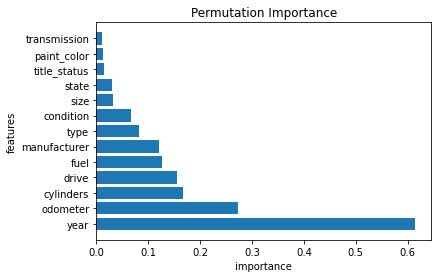

In [14]:
p_impt_result = pd.DataFrame({"Feature": global_X_trainval.columns.to_list(), 
                              "importances_mean": p_impt['importances_mean'],
                              "importances_std": p_impt['importances_std']}).sort_values(by=['importances_mean'], 
                                                                                          ascending=False)
p_impt_result
plt.barh(p_impt_result['Feature'], p_impt_result['importances_mean'])
plt.title("Permutation Importance");
plt.xlabel("importance");
plt.ylabel("features");

### Use Random Forest to select features

We use random forest to select features for the best model (Gradient Boositng). After the pre-processing, there are 90 features in the best Gradeint Boosting model from the task 4. 

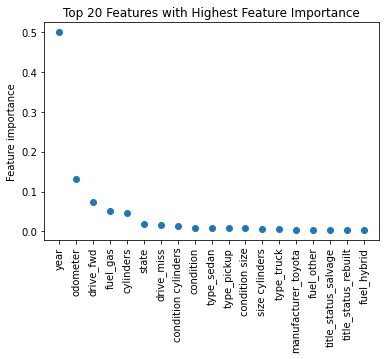

In [66]:
col_names = list(pipeline.named_steps['preprocess'].transformers_[0][1].named_steps['cat_pre'].get_feature_names_out(categorical))+\
            list(pipeline.named_steps['preprocess'].transformers_[1][1].named_steps['ord_poly'].get_feature_names_out(ordinal))+\
            ['odometer']+['year']+target
coef = pd.Series(best_model.feature_importances_, index = col_names)
coef = coef.sort_values(ascending = False)[0:19]
plt.scatter(coef.index, coef)
plt.xticks(rotation=90)
plt.gca().set(ylabel='Feature importance', title='Top 20 Features with Highest Feature Importance')
plt.show()

In [21]:
## Best model from task 4
# best_model = best_grid.best_estimator_.named_steps['regressor']
best_model = pipeline.named_steps['regressor'].regressor_

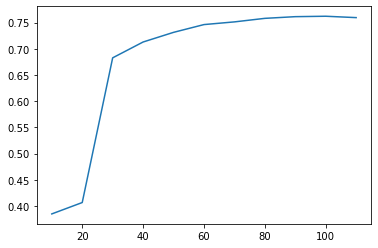

In [88]:
from sklearn.feature_selection import RFECV
rfecv = Pipeline([('pre_processing',preprocess),
                 ('rfecv',RFECV(estimator=best_model, step=10, cv=5))])
rfecv.fit(global_X_trainval, global_y_trainval)
scores = rfecv.named_steps['rfecv'].cv_results_['mean_test_score']
plt.plot(np.array(range(1, len(scores) + 1))*10, scores);

In [92]:
import warnings
warnings.filterwarnings("ignore")

# Find the number of features to keep at various thresholds
thresholds = [1e-1, 1e-2, 5e-3, 1e-3, 0]
result = []
pipe_list = []
select_rf_list = []

X_trainval_processed = preprocess.transform(global_X_trainval)
for i in thresholds:
    select_rf = SelectFromModel(RandomForestRegressor(random_state = 0), threshold=i)

    pipe_rf = Pipeline([('preprocess',preprocess),
                        ('feature_selection',select_rf),
                        ('regressor', best_model)])
    pipe_list.append(pipe_rf)
    
    mean_score = np.mean(cross_val_score(pipe_rf, global_X_trainval, global_y_trainval, cv=5))
    
    select_rf.fit(X_trainval_processed, global_y_trainval)
    select_rf_list.append(select_rf)
    
    result.append((select_rf.transform(X_trainval_processed).shape[1] , mean_score))

In [93]:
result_df = {"threshold": thresholds, "mean_R2": [r for (_,r) in result], 
             "num_feature": [n for (n,_) in result]}
pd.DataFrame(result_df)

,threshold,mean_R2,num_feature
0,0.100,0.407289,2
1,0.010,0.672109,11
2,0.005,0.700094,21
3,0.001,0.754019,59
4,0.000,0.755798,92


There are initially 92 features in total. Removing subsets of features lowers the model performace. Using SelectFromModel(), we find that there are 21 features that, when included in the model, can perform as acceptably well (\\(R^2 = 0.70\\)) as including all features (\\(R^2=0.76\\)).

In [122]:
#' Get feature names
#' order matters!
col_names = list(pipeline.named_steps['preprocess'].transformers_[0][1].named_steps['cat_pre'].get_feature_names_out(categorical))+\
            list(pipeline.named_steps['preprocess'].transformers_[1][1].named_steps['ord_poly'].get_feature_names_out(ordinal))+\
            ['odometer']+['year']+target

picked_index = 2  
selected_features = []
for pipe in pipe_list:
    mask = pipe.named_steps['feature_selection'].get_support().tolist()
    coef = pipe.named_steps['regressor'].feature_importances_
    selected_features.append(pd.DataFrame({'Feature': np.array(col_names)[mask], 'Coef': coef[mask]}))

,Feature,Coef
0,fuel_gas,0.051288
1,fuel_other,0.004339
2,drive_fwd,0.072691
3,drive_miss,0.015540
4,type_pickup,0.008166
5,type_sedan,0.008328
6,type_truck,0.005964
7,manufacturer_chevrolet,0.002826
8,manufacturer_ford,0.002709
9,manufacturer_mercedes-benz,0.001789


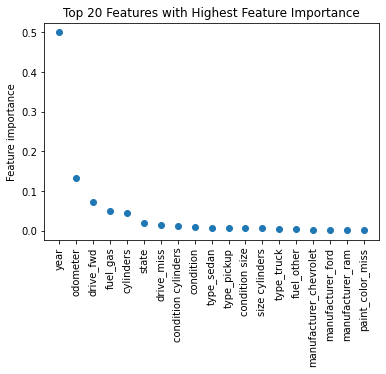

In [140]:
coef = selected_features[picked_index].set_index('Feature')['Coef']
coef = coef.sort_values(ascending = False)
plt.scatter(coef.index, coef)
plt.xticks(rotation=90)
plt.gca().set(ylabel='Feature importance', title='Top 20 Features with Highest Feature Importance')
plt.show()

## Task 6 An Explanable Model {-}

### Feature Selection on Linear Regression Model {-}

We use a linear regression to model the price. We still use random forest to select features to include in the model. (In addition to linear regression, we tried a Decision Tree Regressor, but it did not do as well as a linear regression model–code not shown.)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Find the number of features to keep at various thresholds
thresholds = [1e-1, 1e-2, 5e-3, 1e-3, 0]
result = []
pipe_list = []
select_rf_list = []

X_trainval_processed = preprocess.transform(global_X_trainval)
for i in thresholds:
    select_rf = SelectFromModel(RandomForestRegressor(random_state = 0), threshold=i)

    pipe_rf = Pipeline([('preprocess',preprocess),
                        ('feature_selection',select_rf),
                        ('regressor', DecisionTreeRegressor())])
    pipe_list.append(pipe_rf)
    
    mean_score = np.mean(cross_val_score(pipe_rf, global_X_trainval, global_y_trainval, cv=5))
    
    select_rf.fit(X_trainval_processed, global_y_trainval)
    select_rf_list.append(select_rf)
    
    result.append((select_rf.transform(X_trainval_processed).shape[1] , mean_score))

In [19]:
thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 0]
result = []
pipe_list = []
select_rf_list = []
for i in thresholds:

    select_rf = SelectFromModel(RandomForestRegressor(random_state = 0), threshold=i)

    pipe_rf = Pipeline([('preprocess',preprocess),
                        ('feature_selection',select_rf),
                        ('lr', LinearRegression())])
    pipe_list.append(pipe_rf)
    
    mean_score = np.mean(cross_val_score(pipe_rf, global_X_trainval, global_y_trainval, cv=10))
    
    select_rf.fit(X_trainval_processed, global_y_trainval)
    select_rf_list.append(select_rf)
    
    result.append((select_rf.transform(X_trainval_processed).shape[1] , mean_score))
    

D:\Ananconda\install\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
D:\Ananconda\install\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
D:\Ananconda\install\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


NameError: name 'X_trainval_processed' is not defined

In [ ]:
result_df = {"threshold": thresholds, "mean_R2": [r for (_,r) in result], 
             "num_feature": [n for (n,_) in result]}
pd.DataFrame(result_df)

Including only a subset of features decreases \\(R^2\\) a bit. There are initially 90 features in total. Using SelectFromModel(), we find that the model can perform eqaully well (\\(R^2 = 0.63\\)) when we include the same set of 9 features. The test score of this explanable linear regression model is 0.65.

In [35]:
#' use the same `features` as defined in task 5
picked_index = 1
feature_names = []
for pipe in select_rf_list:
    
    mask = pipe.get_support().tolist()
    feature_names.append([x for x,y in zip(features,mask) if y==True])
print("Features: ", feature_names[picked_index])

Features:  ['fuel_diesel', 'drive_4wd', 'drive_fwd', 'type_pickup', 'cylinders_4.0', 'cylinders_8.0', 'odometer', 'state', 'year']


In [36]:
pipe_list[picked_index].fit(X_trainval_complete, y_trainval_complete)
print("Test score (with 9 features): {:.3f}".format(pipe_list[picked_index].score(global_X_test_complete, global_y_test_complete)))

Test score (with 9 features): 0.651


In [40]:
coef = pipe_list[picked_index].named_steps['lr'].coef_
summary = pd.DataFrame({'feature':feature_names[picked_index],'coeficient':coef, 'abs_coeficient': abs(coef), 'sign': np.sign(coef)})\
                .sort_values('abs_coeficient',ascending=False)
summary[['feature', 'coeficient']]

,feature,coeficient
0,fuel_diesel,10742.306744
6,odometer,-4390.743649
3,type_pickup,3844.836846
4,cylinders_4.0,-3269.629275
2,drive_fwd,-3013.130615
5,cylinders_8.0,2326.934339
1,drive_4wd,2146.409037
8,year,449.830533
7,state,0.415440


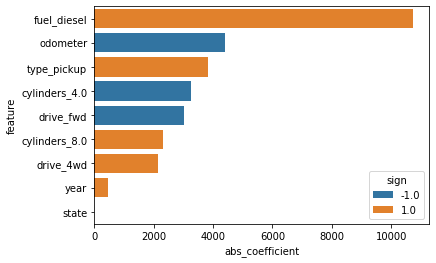

In [38]:
sns.barplot(x=summary['abs_coefficient'], y=summary['feature'], hue = summary['sign'],dodge=False);

On average

* A car that takes diesel has higher price set.
* The further a car has run (odometer), the lower the price.
* A car with 8 cylinders has higher price and a car with 4 cylinders has lower price.
* The newer a car, the higher the price.